<a href="https://colab.research.google.com/github/OmarURP/Tratamiento_Datos/blob/master/01_Simulacion_Embalse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Calculo del volúmen mínimo - Simulación de un embalse con demanda agrícola y pública urbana**
---
## *Subcoordinación de Posgrado y Educación Continua.*
### [Instituto Mexicano de Tecnología del Agua](https://www.gob.mx/imta).<br>
#### ***Asignatura: [FEISH-20] Fenómenos Transitorios***
---
<img src="https://pbs.twimg.com/profile_images/865258640336314369/nbpGVQT0_400x400.jpg" height="150" align="middle">

**Elaborado por: Ariosto Aguilar Chávez, Gibrán Mubarqui Guevara, Elizabeth Rosario Hernández Barrientos, Omar Ulises Robles Pereyra** <br>

# **Determinación de la extracción mínima en un embalse**

Sea el modelo de balance de masa del funcionamiento de un embalse:<br>

$$\frac{dV}{dt}=QI-QR  \hspace{1cm}   (1)$$

donde $t\in [0,T_f)$ es el tiempo como variable independiente; $T_f$ el tiempo de evaluación final; $V(t)$, el volumen como variable dependiente; $QI(t)$, registro de volumen de ingreso al embalse, y $QR(t)$, política de extracción para suministro ( para us agrícola, industrial o público urbano).<br>

Aplicando una discretización en diferencias finitas a la ecuación (1) se tiene:

$$V^{n+1}=V^n+{QI}^n-{QR}^n \hspace{1cm}   (2)$$

donde $V^n=\{V^0,V^1,\dotsb,V^n,\dotsb,V^N\}$ es el conjunto discreto de valores del volumen evaluados en cada intervalo discreto del tiempo $t=\{0,\dotsb,n \Delta t,\dotsb,N \Delta t\}$, donde $\Delta t=T_f/N$, es el incremento de tiempo y $N$ es el número de intervalos de discretización.

En la ecuación (2) el volumen de extracción se puede evaluar como:

$${QR}^n=C^nI+{e}^n A^n \hspace{1cm} (3)$$

donde $I$, es el volumen de extracción anual; $C^n$ es la fracción de la extracción mensual; $A^n$, área del espejo del agua en función del nivel del embalse, $A^n(V^n)$, y $e^n$, es la evaporación media mensual registrada en la zona.

Modelo de avaluaciones capacidades el embalse

En función de topografía

In [1]:
# Importando las librerías
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

In [2]:
# Cargando la dirección de los datos
ruta='/content/data_simulacion.mat'

# Leyendo el archivo (.mat)
datos=sio.loadmat(ruta,simplify_cells=True)
print(datos.keys())

dict_keys(['__header__', '__version__', '__globals__', 'C_d_DR', 'C_d_PubUrb', 'QI', 'coef_vol_area', 'evap'])


In [3]:
# Guardando en variables los datos de interés
coef_vol_area = datos['coef_vol_area'] # Coeficiente de la curva de volúmenes (Mm^3)
C_d_Dr        = datos['C_d_DR']        # Variacion de la demanda agrícola
C_d_PubUrb    = datos['C_d_PubUrb']    # Variación de la demanda público urbana
evap          = datos['evap']          # Evaporación
QI            = datos['QI']            # Gasto de ingreso mensual (Mm^3)

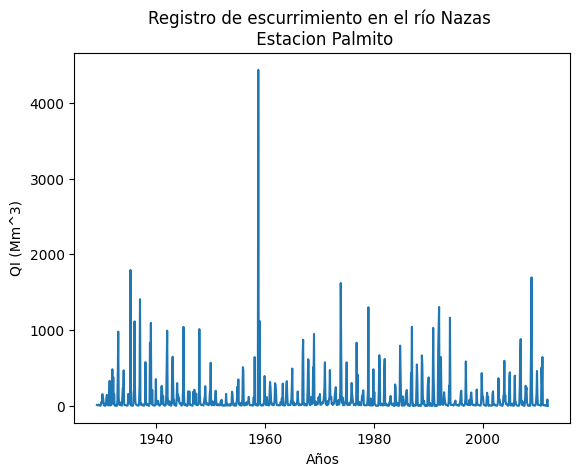

In [4]:
# ---------Figura 1----------
# Impresión del hidrograma
# Se crea un vector del 1 hasta el número de datos de QI, de 1 en 1
t = np.linspace(1,len(QI),len(QI)) # np.linspace(inicio, fin, pasos)

# Convirtiendo de días a años apartir del año de inicio de registros (1929)
anos = 1929 + (t/12)

# Graficando el hidrograma
plt.plot(anos, QI) # plt.plot(ejeX, ejeY)
plt.xlabel('Años'); # Texto en eje X
plt.ylabel('QI (Mm^3)'); # Texto en eje Y
plt.title('Registro de escurrimiento en el río Nazas \n Estacion Palmito'); # Título de figura

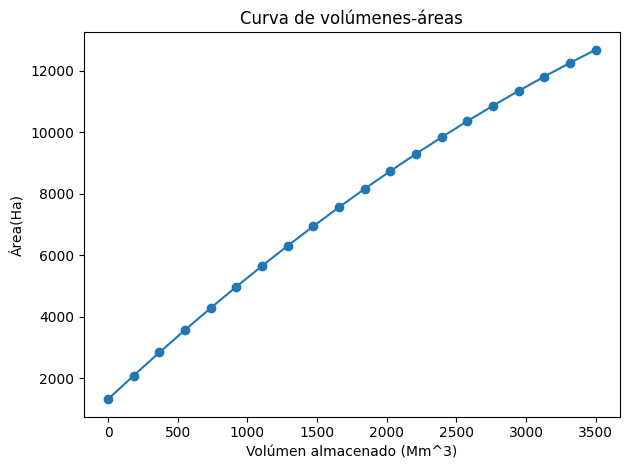

In [5]:
# ---------Figura 2 ----------
# Impresión de curva volúmenes-áreas
# Creando un vector de 0 a 3500 en 20 pasos
volumenes = np.linspace(0, 3500, 20)

# Evaluando los valores de 'coef_vol_area' en los valores del vector 'volúmenes'
polival = np.polyval(coef_vol_area, volumenes)

plt.plot(volumenes, polival, 'o-')
plt.xlabel('Volúmen almacenado (Mm^3)'); # Texto en eje X
plt.ylabel('Área(Ha)'); # Texto en eje Y
plt.title('Curva de volúmenes-áreas'); # Título de figura
plt.tight_layout()

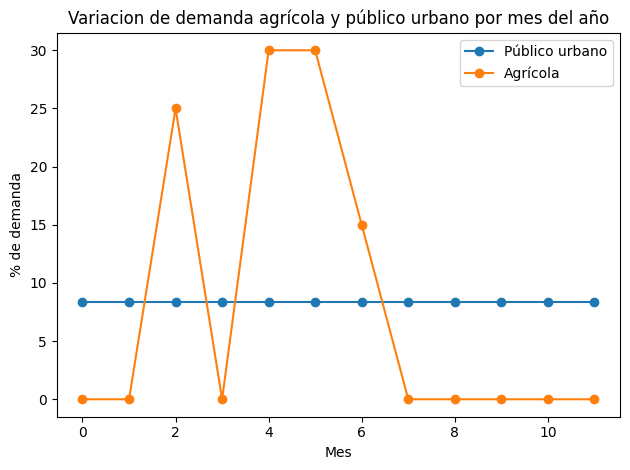

In [6]:
# ---------Figura 3 ----------
# Impresión de demandas de agua por cada uso
plt.plot(C_d_PubUrb, 'o-', label='Público urbano') # Variacion de demanda PubUrb
plt.plot(C_d_Dr, 'o-', label='Agrícola') # Variacion de demanda Agrícola
plt.xlabel('Mes'); # Texto en eje X
plt.ylabel('% de demanda'); # Texto en eje Y
plt.title('Variacion de demanda agrícola y público urbano por mes del año'); # Título de figura
plt.legend() # Impresion de simbología
plt.tight_layout() # Ajuste de figura

In [7]:
# Determinación de la demanda máxima sin fallos
# Tamaño del embalse en Mm3
S = 3200
# Porcentaje de demanda agrícola y público urbana
P_DR = 0.8
P_Pub_urb = 1 - P_DR

# Creando un vector de ceros para los datos del ciclo
V_PicoSec = np.zeros(len(QI))

V_PicoSec[0] = S/2  # Volumen inicial
I = 1   # Demanda inicial global
I_DR = I * P_DR
I_Pub_urb = I * P_Pub_urb
n_r = 1

fallo = 0
while fallo == 0:
    j = 9  # En Python los índices empiezan en 0, entonces octubre es índice 9 [Enero0-Diciembre11]
    for i in range(len(QI) - n_r):
        area = np.polyval(coef_vol_area, V_PicoSec[i]) * 1e4
        Vevap = area * evap[j] / 1e9
        V_PicoSec[i+1] = V_PicoSec[i] + QI[i] - I_DR * C_d_Dr[j]/100.0 - I_Pub_urb * C_d_PubUrb[j]/100.0 - Vevap
        j = j + 1
        if j > 11:
            j = 0
        if V_PicoSec[i+1] > S:
            V_PicoSec[i+1] = S

    if np.min(V_PicoSec) < 0:
        fallo = 1
        I = I - 1
    else:
        I = I + 1

    I_DR = I * P_DR
    I_Pub_urb = I * P_Pub_urb
print('----------Pico Secuente----------')
print(f'Dotación sin fallos = {I:.2f} Mm3')
print(f'Dotación sin fallos agrícola = {I*P_DR:.2f} Mm3')
print(f'Dotación sin fallos Pub_Urb = {I*P_Pub_urb:.2f} Mm3')

----------Pico Secuente----------
Dotación sin fallos = 749.00 Mm3
Dotación sin fallos agrícola = 599.20 Mm3
Dotación sin fallos Pub_Urb = 149.80 Mm3


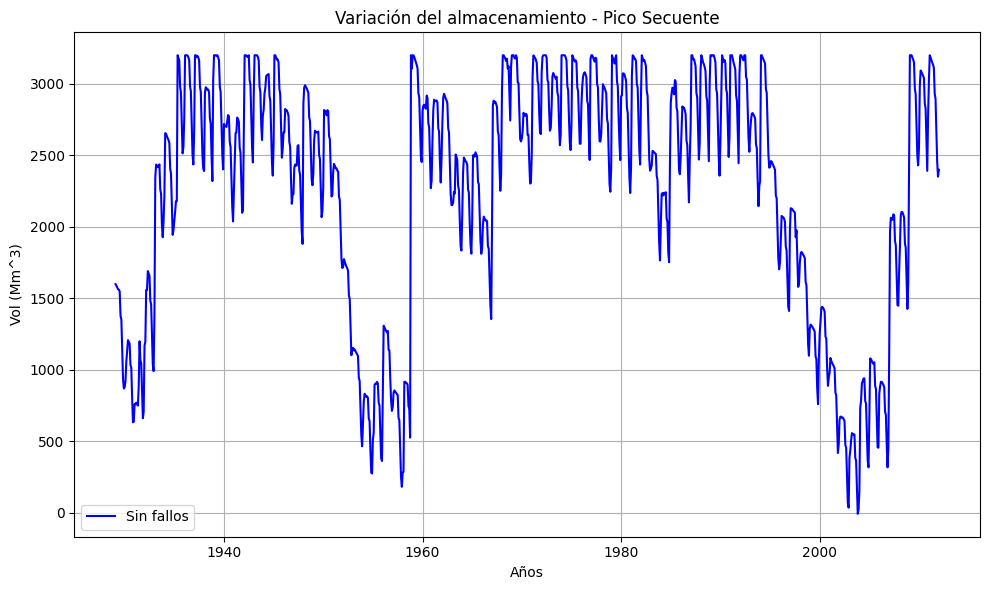

In [8]:
# ----------Gráfica de operación sin fallos---------
plt.figure(figsize=(10, 6))
plt.plot(anos, V_PicoSec, 'b', label='Sin fallos')
plt.xlabel('Años')
plt.ylabel('Vol (Mm^3)')
plt.title('Variación del almacenamiento - Pico Secuente')
plt.grid(True)
plt.legend()
plt.tight_layout()

In [9]:
# Determinacion de demandas adicionales considerando los criterios de garantia
# Definición de criterios de garantía (usando SRH como ejemplo)
Def_anual = 40
Def_bianual = 60
Def_decenal = 80

# Se propone como demanda minima sin fallos
I_g = I
I_DR = I_g * P_DR
I_Pub_urb = I_g * P_Pub_urb

# Creando un vector de ceros para los datos del ciclo
V_Econ = np.zeros(len(QI))

fallo_m = np.zeros(len(QI))
vertido = np.zeros(len(QI))
Vevap_array = np.zeros(len(QI))
g_anual = np.zeros(len(QI))
g_bianual = np.zeros(len(QI))
g_decenal = np.zeros(len(QI))

fallo = 0
while fallo == 0:
    j = 9
    V_Econ[0] = S/2  # volumen inicial
    fallo_m[:] = 0
    vertido[:] = 0
    Vevap_array[:] = 0
    g_anual[:] = 0
    g_bianual[:] = 0
    g_decenal[:] = 0

    for i in range(len(QI) - n_r):
        area = np.polyval(coef_vol_area, V_Econ[i]) * 1e4
        Vevap_array[i] = area * evap[j] / 1e9
        V_Econ[i+1] = V_Econ[i] + QI[i] - I_DR * C_d_Dr[j]/100.0 - I_Pub_urb * C_d_PubUrb[j]/100.0 - Vevap_array[i]
        j = j + 1
        if j > 11:
            j = 0
        if V_Econ[i+1] < 0:
            fallo_m[i+1] = abs(V_Econ[i+1])
            V_Econ[i+1] = 0
        if V_Econ[i+1] > S:
            vertido[i+1] = V_Econ[i+1] - S
            V_Econ[i+1] = S

    # calculo de la garantia anual, bi-anual y decenal
    for i in range(12, len(QI) - n_r):
        g_anual[i] = np.sum(fallo_m[i-12:i+1])

    for i in range(24, len(QI) - n_r):
        g_bianual[i] = np.sum(fallo_m[i-24:i+1])

    for i in range(120, len(QI) - n_r):
        g_decenal[i] = np.sum(fallo_m[i-120:i+1])

    if ((np.max(g_anual)/I_g*100 < Def_anual) and
        (np.max(g_bianual)/I_g*100 < Def_bianual) and
        (np.max(g_decenal)/I_g*100 < Def_decenal)):
        I_g = I_g + 0.1
    else:
        fallo = 1

    I_DR = I_g * P_DR
    I_Pub_urb = I_g * P_Pub_urb

# Registro de octubre
k = 0
reg_oct = []
j = 9
for i in range(len(QI) - n_r):
    if j == 9:
        reg_oct.append(V_Econ[i])
    j = j + 1
    if j > 11:
        j = 0
print('----------Criterio Económico----------')
print(f'Dotacion con fallos = {I_g:.2f} Mm3')
print(f'Dotacion con fallos agricola = {I_g*P_DR:.2f} Mm3')
print(f'Dotacion con fallos Pub_Urb = {I_g*P_Pub_urb:.2f} Mm3')
print('--------------------------------------')
print(f'Garantia anual = {np.max(g_anual)/I_g*100:.2f}')
print(f'Garantia bianual = {np.max(g_bianual)/I_g*100:.2f}')
print(f'Garantia decenal = {np.max(g_decenal)/I_g*100:.2f}')
print(f'Derrames (porcentaje) = {np.sum(vertido)/np.sum(QI[:len(QI)-n_r])*100:.2f}')
print(f'Fallos (porcentaje) = {np.sum(fallo_m)/np.sum(QI[:len(QI)-n_r])*100:.2f}')
print(f'Evaporacion (porcentaje) = {np.sum(Vevap_array)/np.sum(QI[:len(QI)-n_r])*100:.2f}')
print(f'Eficiencia (porcentaje) = {(np.sum(QI[:len(QI)-n_r])-np.sum(vertido)-np.sum(fallo_m)-np.sum(Vevap_array))/np.sum(QI[:len(QI)-n_r])*100:.2f}')

----------Criterio Económico----------
Dotacion con fallos = 801.90 Mm3
Dotacion con fallos agricola = 641.52 Mm3
Dotacion con fallos Pub_Urb = 160.38 Mm3
--------------------------------------
Garantia anual = 40.01
Garantia bianual = 47.10
Garantia decenal = 47.10
Derrames (porcentaje) = 17.41
Fallos (porcentaje) = 0.62
Evaporacion (porcentaje) = 17.04
Eficiencia (porcentaje) = 64.93


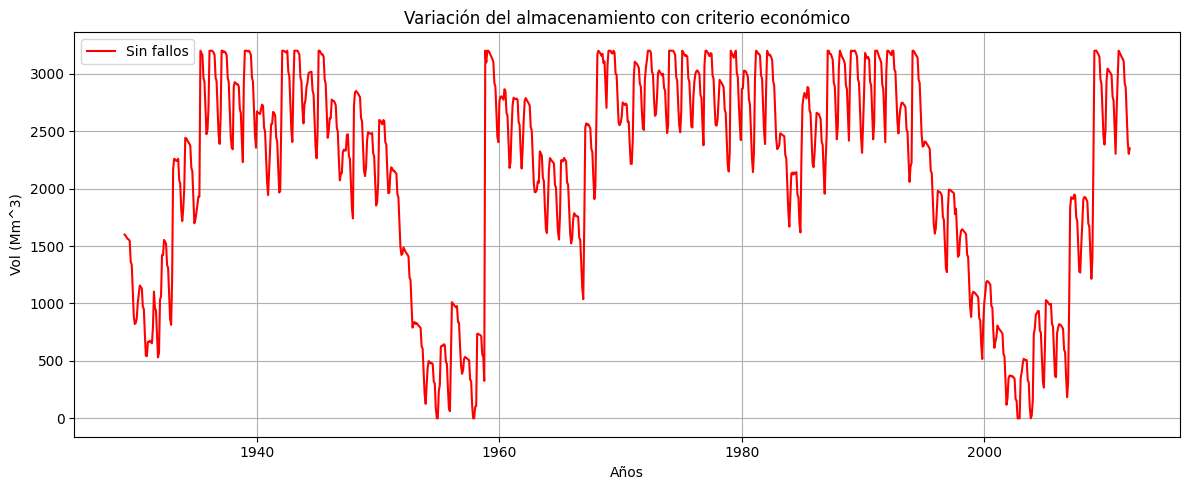

In [10]:
# Gráfica de operación con fallos
plt.figure(figsize=(12, 5))
plt.plot(anos, V_Econ, 'r', label='Sin fallos')
plt.xlabel('Años')
plt.ylabel('Vol (Mm^3)')
plt.title('Variación del almacenamiento con criterio económico')
plt.grid()
plt.legend()
plt.tight_layout()

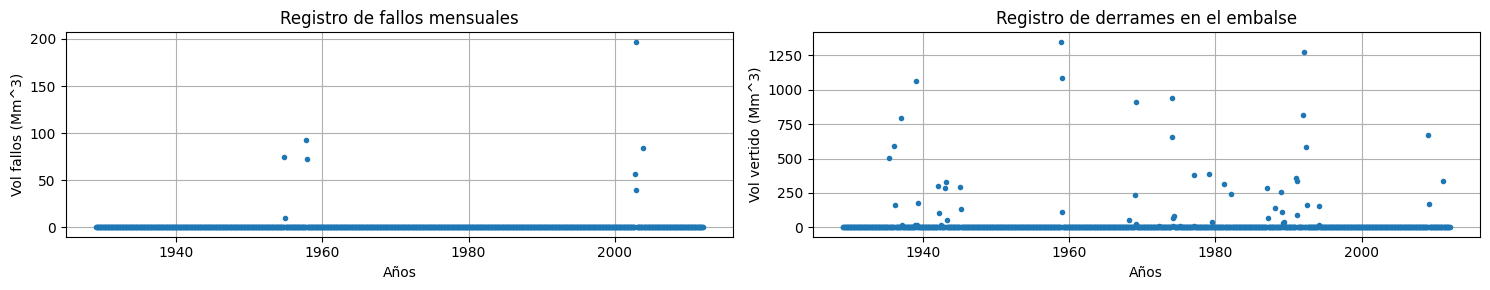

In [11]:
# Registro de fallos y vertidos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))

# Subplot 1: Fallos mensuales
ax1.plot(anos, fallo_m, '.')
ax1.set_xlabel('Años')
ax1.set_ylabel('Vol fallos (Mm^3)')
ax1.set_title('Registro de fallos mensuales')
ax1.grid(True)

# Subplot 2: Vertidos
ax2.plot(anos, vertido, '.')
ax2.set_xlabel('Años')
ax2.set_ylabel('Vol vertido (Mm^3)')
ax2.set_title('Registro de derrames en el embalse')
ax2.grid(True)

plt.tight_layout()

----------Pico Secuente---------------
Dotacion sin fallos = 749.00 Mm3
Dotacion sin fallos agricola = 599.20 Mm3
Dotacion sin fallos Pub_Urb = 149.80 Mm3
----------Criterio Económico----------
Dotacion con fallos = 801.90 Mm3
Dotacion con fallos agricola = 641.52 Mm3
Dotacion con fallos Pub_Urb = 160.38 Mm3


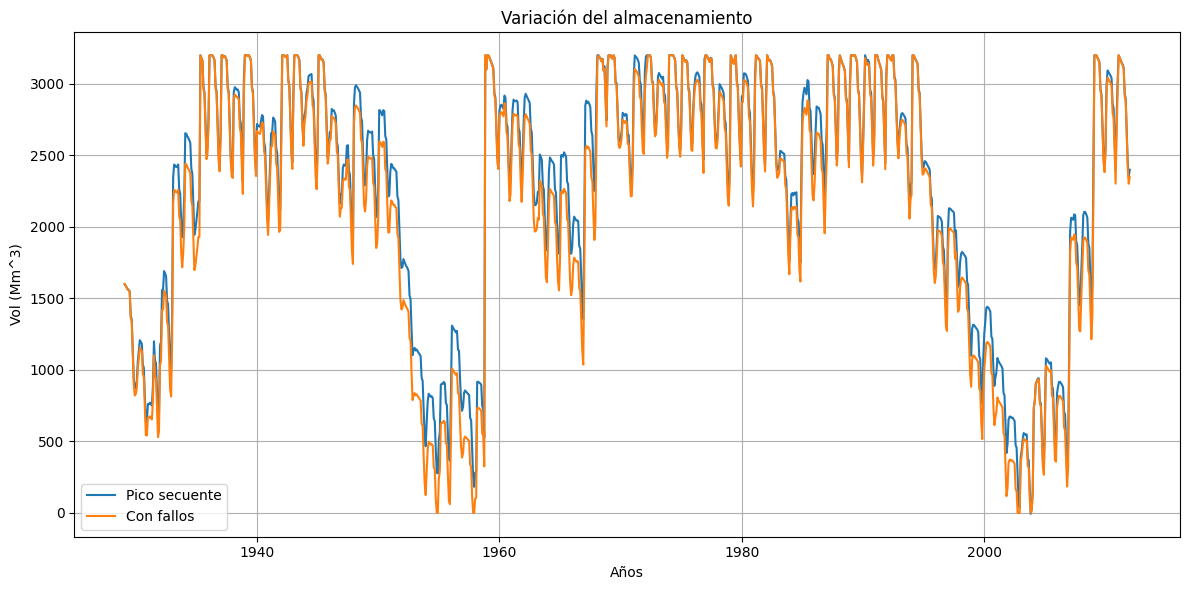

In [15]:
# Resumen de resultados
print('----------Pico Secuente---------------')
print(f'Dotacion sin fallos = {I:.2f} Mm3')
print(f'Dotacion sin fallos agricola = {I*P_DR:.2f} Mm3')
print(f'Dotacion sin fallos Pub_Urb = {I*P_Pub_urb:.2f} Mm3')
print('----------Criterio Económico----------')
print(f'Dotacion con fallos = {I_g:.2f} Mm3')
print(f'Dotacion con fallos agricola = {I_g*P_DR:.2f} Mm3')
print(f'Dotacion con fallos Pub_Urb = {I_g*P_Pub_urb:.2f} Mm3')
# Gráfica de operación con fallos y sin fallos
plt.figure(figsize=(12, 6))
plt.plot(anos, V_PicoSec, label='Pico secuente')
plt.plot(anos, V_Econ, label='Con fallos')
plt.xlabel('Años')
plt.ylabel('Vol (Mm^3)')
plt.title('Variación del almacenamiento')
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()